<a href="https://colab.research.google.com/github/MelchiorReihlenBorgers/EstimatingTheWeightOfCows/blob/master/EstimateCarcassWeight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carcass Weight Estimation

## Libraries

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

import cv2

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

In [ ]:
path = "/content/drive/My Drive/Master/Thesis"

os.chdir(path)

Get all paths to directories + subdirectories

In [ ]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

Calculate the z-score

In [ ]:
def calculate_z_score(keypoint_depth_value, p1, p2):

  z_score = abs(keypoint_depth_value[p1] - keypoint_depth_value[p2])

  return z_score

Calculate the XY needed for distance calculation

In [ ]:
def calculations(AspectRatio, radian, keypoint_depth_value, estimated_keypoints, p1, p2):

        depth_value_p1 = keypoint_depth_value[p1]
        depth_value_p2 = keypoint_depth_value[p2]

        x_p1 = estimated_keypoints[p1, 1]
        y_p1 = estimated_keypoints[p1, 0]
        x_p2 = estimated_keypoints[p2, 1]
        y_p2 = estimated_keypoints[p2, 0]

        oneFrameWidth = np.tan(radian) * depth_value_p1
        oneFrameHeight = oneFrameWidth * AspectRatio

        twoFrameWidth = np.tan(radian) * depth_value_p2
        twoFrameHeight = twoFrameWidth * AspectRatio

        onePercentX = x_p1 /4032
        onePercentY = y_p1 /3024

        twoPercentX = x_p2 /4032
        twoPercentY = y_p2 /3024

        oneDistanceFromCenterX = -(oneFrameWidth/2) + (oneFrameWidth * onePercentX)
        oneDistanceFromCenterY = -(oneFrameHeight/2) + (oneFrameHeight * onePercentY)
        twoDistanceFromCenterX = -(twoFrameWidth/2) + (twoFrameWidth * twoPercentX)
        twoDistanceFromCenterY = -(twoFrameHeight/2) + (twoFrameHeight * twoPercentY)

        x = max(np.maximum(oneDistanceFromCenterX, twoDistanceFromCenterX)) - \
            min(np.minimum(oneDistanceFromCenterX, twoDistanceFromCenterX))
        y = max(np.maximum(oneDistanceFromCenterY, twoDistanceFromCenterY)) - \
            min(np.minimum(oneDistanceFromCenterY, twoDistanceFromCenterY))

        return (x, y)

Function to calculate body measures

In [ ]:
def calculate_body_measure(xys, z_score):
  x, y = xys
  
  body_measure = x**2 + y**2 + z_score**2

  return body_measure

## 1) Body Measure Calculation

### Load Images, Depths and Radians

**Load Estimated Keypoints**

In [ ]:
os.chdir(os.path.join(path, "Heatmaps"))

In [ ]:
estimated_keypoints = np.load("estimated_keypoints.npy")

print("The shape of the estimated keypoints is: {}".format(np.shape(estimated_keypoints)))

The shape of the estimated keypoints is: (576, 2)


In [ ]:
## Resize the keypoints as they are fitted on a 192 x 192 image
adujst_width = 4032/192
adjust_height = 3024/192

print("Adjust the width and height by: {} and {}".format(adujst_width, adjust_height))

Adjust the width and height by: 21.0 and 15.75


In [ ]:
estimated_keypoints[:,0] = estimated_keypoints[:,0]*adjust_height
estimated_keypoints[:,1] = estimated_keypoints[:,1]*adujst_width

In [ ]:
## Reshape so the data has shape: number of images x number of dimensions (xy coordinates, i.e. 2 dimensions) x number of keypoints
estimated_keypoints = estimated_keypoints.reshape(72, 8, 2).swapaxes(1,2)

print("The shape of the keypoints is: {}".format(estimated_keypoints.shape))

The shape of the keypoints is: (72, 2, 8)


**Load the images, depths and radians**

 a) Images

In [ ]:
# Create the image data set

## Get the path to the images
path = "/content/drive/My Drive/Master/Thesis/images"

## Change the working directory
os.chdir(path)

## Get the list of all the files
files = os.listdir(path)

## Get the number of images
n_images = len(files)
print("{} images found in directory".format(n_images))

## Read in the images
images = [plt.imread(file) for file in files]
print("{} images loaded".format(len(images)))

images = np.array(images)
print("Shape of the features: {}, i.e. number of images x height x width x color channel".format(np.shape(images)))

72 images found in directory
72 images loaded
Shape of the features: (72, 3024, 4032, 3), i.e. number of images x height x width x color channel


Save the image names 

In [ ]:
image_names = [os.path.basename(file) for file in files]

image_names_no_extension = [os.path.splitext(name)[0] for name in image_names]

print("The first two names without extension: {}".format(image_names_no_extension[:2]))

The first two names without extension: ['585216074-0', '586290717-8']


Save Names of Good Images

In [ ]:
good_images = np.load("/content/drive/My Drive/Master/Thesis/good_images_names.npy")

good_images_no_extension = [os.path.splitext(name)[0] for name in good_images]

good_images_no_extension[:5]

['586290925-7', '589454964-0', '589455079-7', '591158798-0', '591159136-9']

b) Depths

In [ ]:
## Corresponding depth files are called image_names_no_extension + str(".csv")
depth_names = [name + str(".csv") for name in image_names_no_extension]

print("The first two names of the depth maps are: {}".format(depth_names[:2]))

The first two names of the depth maps are: ['585216074-0.csv', '586290717-8.csv']


*Load the good depths*

In [ ]:
## Corresponding depth files are called image_names_no_extension + str(".csv")
depth_names_good_images = [name + str(".csv") for name in good_images_no_extension]

print("The first two names of the depth maps are: {}".format(depth_names_good_images[:2]))

The first two names of the depth maps are: ['586290925-7.csv', '589454964-0.csv']


*Load All Paths*

In [ ]:
path = "/content/drive/My Drive/Master/Thesis/Cow_Images_T"

AllPaths = getListOfFiles(path)

print("There are a total of {} paths detected.".format(len(AllPaths)))

There are a total of 500 paths detected.


*Load All Depth Paths*

In [ ]:
depth_paths = []

for path in AllPaths:
  for index, depth_name in enumerate(depth_names):
    if path.endswith(depth_names[index]):
      depth_paths.append(path)

print("{} Depths detected".format(len(depth_paths)))

72 Depths detected


*Load Good Depth Paths*

In [ ]:
depth_paths_good_images = []

for path in AllPaths:
  for index, depth_name in enumerate(depth_names_good_images):
    if path.endswith(depth_names_good_images[index]):
      depth_paths_good_images.append(path)

print("{} Good Depths detected".format(len(depth_paths_good_images)))

29 Good Depths detected


Load Depths

In [ ]:
depths = [np.array(pd.read_csv(depth, header = None)) for depth in depth_paths]

print("The number of depths loaded: {}".format(len(depths)))

The number of depths loaded: 72


In [ ]:
depths_good_image = [np.array(pd.read_csv(depth, header = None)) for depth in depth_paths_good_images]

print("The number of good depths loaded: {}".format(len(depths_good_image)))

The number of good depths loaded: 29


Resize Depths

In [ ]:
depths = [cv2.resize(depths[index], (4032, 3024)) for index, depth in enumerate(depths)]

In [ ]:
depths_good_image = [cv2.resize(depths_good_image[index], (4032, 3024)) for index, depth in enumerate(depths_good_image)]

In [ ]:
plt.imshow(depths[1])
plt.title(image_names_no_extension[1])
plt.axis("off")
plt.show()

c) Radian

In [ ]:
## Radians are saved in files called N-info.txt where N = 1, 2, ... , 72

radian_names = [str(number + 1)  + "-info.txt" for number in range(72)]

print("The first two radian names are: {}".format(radian_names[:2]))
print("The last two radian names are: {}".format(radian_names[-2:]))

The first two radian names are: ['1-info.txt', '2-info.txt']
The last two radian names are: ['71-info.txt', '72-info.txt']


In [ ]:
radian_paths = []

for path in AllPaths:
  for index, radian_name in enumerate(radian_names):
    if path.endswith(radian_names[index]):
      radian_paths.append(path)

radian_paths = np.unique(radian_paths)
print("{} Radians detected".format(len(radian_paths)))

68 Radians detected


Create function to read in radian values

In [ ]:
def read_radian(radians_paths):
  with open(radian_path) as metafile:
    md = metafile.read().split(",")
    radian = float(md[2])

  return radian

In [ ]:
radians = []

for radian_path in radian_paths:
  radians.append(read_radian(radian_path))


print("The radian is constant for all the images: {}".format(np.unique(radians)))

## Add the four missing radian values by enlarging the list to len 72
radians = [np.unique(radians)]*len(images)

The radian is constant for all the images: [66.487946]


### Claculate Body Measures from Estimated Keypoints (All Images)




Get the aspects ratio

In [ ]:
## Get aspects ratio 
aspects_ratio = 3024/4032

In [ ]:
estimated_keypoints = estimated_keypoints.swapaxes(1,2)

print(estimated_keypoints.shape)

(72, 8, 2)


Extract the depth values corresponding to the estimated keypoints

In [ ]:
n_depths, kps, coordinates = estimated_keypoints.shape

In [ ]:
depth_values = []

# First Dimension: 72
for depth in range(n_depths):
   
  # Get the KPx and KPy as integers
  for kp in range(kps):
  
    y, x = estimated_keypoints[depth, kp, :]

    depth_values.append(depths[depth][y][x])


## Reshape the depth values to be number of images x keypoints
depth_values = np.array(depth_values).reshape(72,8)

print("The shape of the depth values corresponding to the keypoints is: {} (number of images x keypoint)".format(np.shape(depth_values)))

The shape of the depth values corresponding to the keypoints is: (72, 8) (number of images x keypoint)


Calculate the z-score

In [ ]:
## Calculate z-score fore the different body measures
z_scores_bl = []
z_scores_hh = []
z_scores_hw = []
z_scores_hg = []

for index, image in enumerate(images):
  z_score_bl = calculate_z_score(depth_values[index,:], 0, 1)
  z_score_hh = calculate_z_score(depth_values[index,:], 2, 3)
  z_score_hw = calculate_z_score(depth_values[index,:], 4, 5)
  z_score_hg = calculate_z_score(depth_values[index,:], 6, 7)

  z_scores_bl.append(z_score_bl)
  z_scores_hh.append(z_score_hh)
  z_scores_hw.append(z_score_hw)
  z_scores_hg.append(z_score_hg)

In [ ]:
z_scores = np.array([z_scores_bl, z_scores_hh, z_scores_hw, z_scores_hg]).transpose()

print("The z-score matrix has the following shape: {}".format(z_scores.shape))

The z-score matrix has the following shape: (72, 4)


In [ ]:
xys_bl = []
xys_hh = []
xys_hw = []
xys_hg = []

for index, image in enumerate(images):
  xy_bl = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values[index], estimated_keypoints=estimated_keypoints[index], p1 = 0, p2 = 1)
  xy_hh = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values[index], estimated_keypoints=estimated_keypoints[index], p1 = 2, p2 = 3)
  xy_hw = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values[index], estimated_keypoints=estimated_keypoints[index], p1 = 4, p2 = 5)
  xy_hg = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values[index], estimated_keypoints=estimated_keypoints[index], p1 = 6, p2 = 7)

  xys_bl.append(xy_bl)
  xys_hh.append(xy_hh)
  xys_hw.append(xy_hw)
  xys_hg.append(xy_hg)


xys = np.array([xys_bl, xys_hh, xys_hw, xys_hg]).swapaxes(0,1)

print("The shape of the resulting array with x and y is: {}, i.e. number of images x number of body measures x xy coordinates".format(xys.shape))

The shape of the resulting array with x and y is: (72, 4, 2), i.e. number of images x number of body measures x xy coordinates


Calculate Body Measures

In [ ]:
n_images, n_bms = z_scores.shape

body_measures = []

## Iterate through images and keypoints

for image in range(n_images):

  for bm in range(n_bms):

    iter_xys = xys[image, bm]

    z_score = z_scores[image, bm]

    body_measure = calculate_body_measure(iter_xys, z_score)

    body_measures.append(body_measure)

In [ ]:
body_measures = np.array(body_measures).reshape(72,4)

In [ ]:
body_measures[0,:]

array([5.58366543e-05, 2.90635674e-04, 4.04976031e-04, 8.62421379e-04])

Combine Results

In [ ]:
results_body_measures = pd.DataFrame(body_measures, 
                                     index = image_names,
                                     columns = ["Body_Length", "Hip_Height", "Hip_Width", "Heart_Girth"])

In [ ]:
results_body_measures.head()

,Body_Length,Hip_Height,Hip_Width,Heart_Girth
585216074-0.jpg,0.000056,0.000291,0.000405,0.000862
586290717-8.jpg,0.000046,0.000260,0.000362,0.000752
586290925-7.jpg,0.000112,0.000340,0.000508,0.002040
589454323-0.jpg,0.000082,0.001139,0.000967,0.001749
589454978-8.jpg,0.000048,0.000569,0.000505,0.000785


In [ ]:
results_body_measures.to_csv("/content/drive/My Drive/Master/Thesis/Body Measures Results/results_body_measures.csv")

### Calculate Annotated Body Measures

Load Annotated Keypoints

In [ ]:
os.chdir("/content/drive/My Drive/Master/Thesis/Keypoints")

## Read in the data
keypoint_data = pd.read_csv("labels_keypoints.csv",
                            header = None,
                            names = ["Label", "X", "Y", "Image_Name", "Xdim", "Ydim"])

keypoint_data.head()

,Label,X,Y,Image_Name,Xdim,Ydim
0,back_start,3227,614,595688782-2.jpg,4032,3024
1,back_end,690,1228,595688782-2.jpg,4032,3024
2,hip_end,886,2777,595688782-2.jpg,4032,3024
3,hip_start,937,1480,595688782-2.jpg,4032,3024
4,hip_width_left,1065,972,595688782-2.jpg,4032,3024


In [ ]:
keypoint_label_dict = {"back_start": "p1",
                       "back_end": "p2",
                       "hip_start": "p3",
                       "hip_end": "p4",
                       "hip_width_left": "p5",
                       "hip_width_right": "p6",
                       "girth_start": "p7",
                       "girth_end": "p8"}

In [ ]:
keypoint_data.loc[:,"Label"] = keypoint_data.loc[:,"Label"].map(keypoint_label_dict)

In [ ]:
## Pivot the keypoint data set to have Image as index and Label + X or Label + Y as column.
keypoint_data = keypoint_data.pivot_table(index = "Image_Name", columns = "Label", values = ["X", "Y"]).bfill()

print("\n First 5 rows of pivote keypoint data")
print(keypoint_data.head())

## Reindex to make sure the order of images is the same
keypoint_data = keypoint_data.reindex(image_names)

## Keypoint as numpy array
keypoint_data = np.array(keypoint_data)


 First 5 rows of pivote keypoint data
                      X                          ...       Y                        
Label                p1      p2      p3      p4  ...      p5      p6      p7      p8
Image_Name                                       ...                                
585216074-0.jpg  1645.0  3667.0  3496.0  3249.0  ...  1066.0  1173.0   857.0  1757.0
586290717-8.jpg  3010.0  1227.0  1355.0  3249.0  ...   896.0  1173.0  1100.0  1885.0
586290925-7.jpg  1218.0  3432.0  3385.0  3249.0  ...   896.0   525.0   627.0  1907.0
589454323-0.jpg  2289.0  2460.0  1359.0   736.0  ...  1365.0  1271.0  1621.0  2273.0
589454370-6.jpg  1018.0  3722.0  1359.0   736.0  ...  1390.0  1177.0  1471.0  2273.0

[5 rows x 16 columns]


Get aspects ratio

In [ ]:
## Get aspects ratio 
aspects_ratio = 3024/4032

Extract the depth values corresponding to the annotated keypoints

In [ ]:
keypoint_data = keypoint_data.reshape(72,2,8).swapaxes(1,2)

In [ ]:
n_depths, kps, coordinates = keypoint_data.shape

depth_values_annotated = []

# First Dimension: 72
for depth in range(n_depths):
   
  # Get the KPx and KPy as integers
  for kp in range(kps):
  
    x, y = int(keypoint_data[depth, kp,0]), int(keypoint_data[depth, kp,1])

    depth_values_annotated.append(depths[depth][y][x])


## Reshape the depth values to be number of images x keypoints
depth_values_annotated = np.array(depth_values).reshape(72,8)

print("The shape of the depth values corresponding to the keypoints is: {} (number of images x keypoint)".format(np.shape(depth_values_annotated)))

The shape of the depth values corresponding to the keypoints is: (72, 8) (number of images x keypoint)


Calculate z-score

In [ ]:
## Calculate z-score fore the different body measures
z_scores_bl = []
z_scores_hh = []
z_scores_hw = []
z_scores_hg = []

for index, image in enumerate(images):
  z_score_bl = calculate_z_score(depth_values_annotated[index,:], 0, 1)
  z_score_hh = calculate_z_score(depth_values_annotated[index,:], 2, 3)
  z_score_hw = calculate_z_score(depth_values_annotated[index,:], 4, 5)
  z_score_hg = calculate_z_score(depth_values_annotated[index,:], 6, 7)

  z_scores_bl.append(z_score_bl)
  z_scores_hh.append(z_score_hh)
  z_scores_hw.append(z_score_hw)
  z_scores_hg.append(z_score_hg)

In [ ]:
z_scores_annotated = np.array([z_scores_bl, z_scores_hh, z_scores_hw, z_scores_hg]).transpose()

print("The z-score matrix has the following shape: {}".format(z_scores_annotated.shape))

The z-score matrix has the following shape: (72, 4)


Calculate the XY needed for distance calculation

In [ ]:
xys_bl = []
xys_hh = []
xys_hw = []
xys_hg = []

for index, image in enumerate(images):
  xy_bl = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_annotated[index], estimated_keypoints=keypoint_data[index], p1 = 0, p2 = 1)
  xy_hh = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_annotated[index], estimated_keypoints=keypoint_data[index], p1 = 2, p2 = 3)
  xy_hw = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_annotated[index], estimated_keypoints=keypoint_data[index], p1 = 4, p2 = 5)
  xy_hg = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_annotated[index], estimated_keypoints=keypoint_data[index], p1 = 6, p2 = 7)

  xys_bl.append(xy_bl)
  xys_hh.append(xy_hh)
  xys_hw.append(xy_hw)
  xys_hg.append(xy_hg)


xys_annotated = np.array([xys_bl, xys_hh, xys_hw, xys_hg]).swapaxes(0,1)

print("The shape of the resulting array with x and y is: {}, i.e. number of images x number of body measures x xy coordinates".format(xys_annotated.shape))

The shape of the resulting array with x and y is: (72, 4, 2), i.e. number of images x number of body measures x xy coordinates


In [ ]:
n_images, n_bms = z_scores_annotated.shape

body_measures_annotated = []

## Iterate through images and keypoints

for image in range(n_images):

  for bm in range(n_bms):

    iter_xys = xys_annotated[image, bm]

    z_score = z_scores_annotated[image, bm]

    body_measure = calculate_body_measure(iter_xys, z_score)

    body_measures_annotated.append(body_measure)

In [ ]:
body_measures_annotated = np.array(body_measures_annotated).reshape(72,4)

In [ ]:
results_body_measures_annotated = pd.DataFrame(body_measures_annotated,
                                               index = image_names,
                                               columns = ["Body_Length", "Hip_Height", "Hip_Width", "Heart_Girth"])

In [ ]:
results_body_measures_annotated.head()

,Body_Length,Hip_Height,Hip_Width,Heart_Girth
585216074-0.jpg,0.058128,0.050881,0.083698,0.015838
586290717-8.jpg,0.042164,0.084113,0.073106,0.009901
586290925-7.jpg,0.067637,0.055564,0.005718,0.027797
589454323-0.jpg,0.012839,0.143285,0.017087,0.022151
589454978-8.jpg,0.022090,0.057575,0.000508,0.018019


Compare the estimated and the annotated results

In [ ]:
body_measures.shape

(72, 4)

In [ ]:
body_measures_annotated.shape

(72, 4)

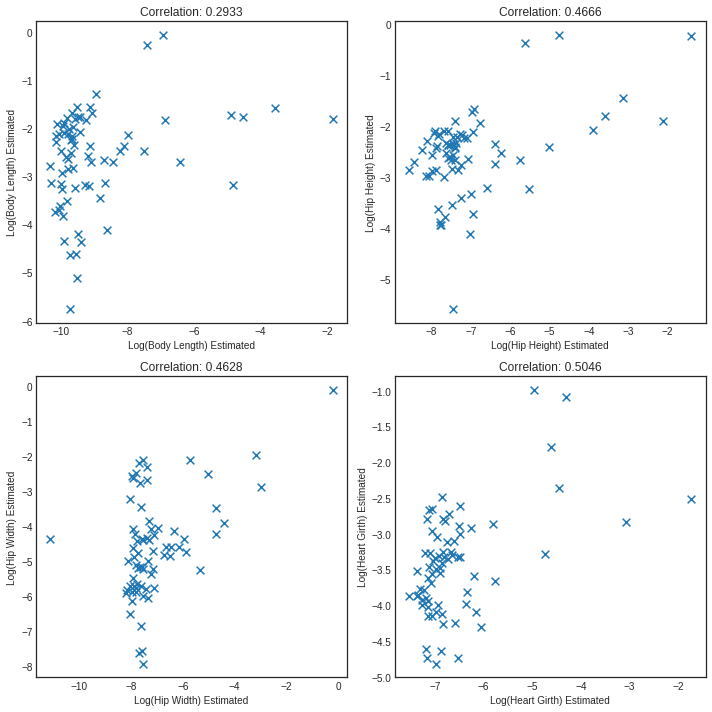

In [ ]:
n_images, n_bms = body_measures.shape

plt.figure(figsize = [10,10])

for index in range(n_bms):
  x = np.log(body_measures[:,index])
  y = np.log(body_measures_annotated[:,index])

  correlation = np.corrcoef(x,y)[0,1].round(4)

  plt.subplot(2,2,index+1)
  
  plt.title("Correlation: " + str(correlation), fontdict = {"fontsize":12})
  plt.scatter(x = x, y = y, marker = "x", s = 60)
  plt.xlabel("Log(" + results_body_measures.columns[index].replace("_", " ") + ")" + " Estimated")
  plt.ylabel("Log(" + results_body_measures_annotated.columns[index].replace("_", " ") + ")" + " Estimated")


plt.tight_layout()
plt.show()

### Calculate Body Measures from Estimated Keypoints (Good Images Only)


Load Estimated Keypoints of Good Images

In [ ]:
estimated_keypoints_good_images = np.load("/content/drive/My Drive/Master/Thesis/Keypoints/estimated_keypoints_good_images.npy")

print("The shape of the estimated keypoints is: {}".format(np.shape(estimated_keypoints_good_images)))

The shape of the estimated keypoints is: (232, 2)


In [ ]:
## Resize the keypoints as they are fitted on a 192 x 192 image
adujst_width = 4032/192
adjust_height = 3024/192

print("Adjust the width and height by: {} and {}".format(adujst_width, adjust_height))

Adjust the width and height by: 21.0 and 15.75


In [ ]:
estimated_keypoints_good_images[:,0] = estimated_keypoints_good_images[:,0]*adjust_height
estimated_keypoints_good_images[:,1] = estimated_keypoints_good_images[:,1]*adujst_width

In [ ]:
## Reshape so the data has shape: number of images x number of dimensions (xy coordinates, i.e. 2 dimensions) x number of keypoints
estimated_keypoints_good_images = estimated_keypoints_good_images.reshape(29, 8, 2)

print("The shape of the keypoints is: {}".format(estimated_keypoints_good_images.shape))

The shape of the keypoints is: (29, 8, 2)


Get aspects ratio

In [ ]:
## Get aspects ratio 
aspects_ratio = 3024/4032

Extract the depth values corresponding to the annotated keypoints

In [ ]:
n_depths, kps, coordinates = estimated_keypoints_good_images.shape

depth_values_good_images = []

# First Dimension: 72
for depth in range(n_depths):
   
  # Get the KPx and KPy as integers
  for kp in range(kps):
  
    x, y = int(estimated_keypoints_good_images[depth, kp,1]), int(estimated_keypoints_good_images[depth, kp,0])

    depth_values_good_images.append(depths_good_image[depth][y][x])


## Reshape the depth values to be number of images x keypoints
depth_values_good_images = np.array(depth_values_good_images).reshape(n_depths,kps)

print("The shape of the depth values corresponding to the keypoints is: {} (number of images x keypoint)".format(np.shape(depth_values_good_images)))

The shape of the depth values corresponding to the keypoints is: (29, 8) (number of images x keypoint)


Calculate z-score

In [ ]:
## Calculate z-score fore the different body measures
z_scores_bl = []
z_scores_hh = []
z_scores_hw = []
z_scores_hg = []

for index, image in enumerate(depths_good_image):
  z_score_bl = calculate_z_score(depth_values_good_images[index,:], 0, 1)
  z_score_hh = calculate_z_score(depth_values_good_images[index,:], 2, 3)
  z_score_hw = calculate_z_score(depth_values_good_images[index,:], 4, 5)
  z_score_hg = calculate_z_score(depth_values_good_images[index,:], 6, 7)

  z_scores_bl.append(z_score_bl)
  z_scores_hh.append(z_score_hh)
  z_scores_hw.append(z_score_hw)
  z_scores_hg.append(z_score_hg)

In [ ]:
z_scores_good_images = np.array([z_scores_bl, z_scores_hh, z_scores_hw, z_scores_hg]).transpose()

print("The z-score matrix has the following shape: {}".format(z_scores_good_images.shape))

The z-score matrix has the following shape: (29, 4)


Calculate the XY needed for distance calculation

In [ ]:
xys_bl = []
xys_hh = []
xys_hw = []
xys_hg = []

for index, image in enumerate(depths_good_image):
  xy_bl = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_good_images[index], estimated_keypoints=estimated_keypoints_good_images[index], p1 = 0, p2 = 1)
  xy_hh = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_good_images[index], estimated_keypoints=estimated_keypoints_good_images[index], p1 = 2, p2 = 3)
  xy_hw = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_good_images[index], estimated_keypoints=estimated_keypoints_good_images[index], p1 = 4, p2 = 5)
  xy_hg = calculations(AspectRatio= 0.75, radian= radians[0], keypoint_depth_value = depth_values_good_images[index], estimated_keypoints=estimated_keypoints_good_images[index], p1 = 6, p2 = 7)

  xys_bl.append(xy_bl)
  xys_hh.append(xy_hh)
  xys_hw.append(xy_hw)
  xys_hg.append(xy_hg)


xys_good_images = np.array([xys_bl, xys_hh, xys_hw, xys_hg]).swapaxes(0,1)

print("The shape of the resulting array with x and y is: {}, i.e. number of images x number of body measures x xy coordinates".format(xys_good_images.shape))

The shape of the resulting array with x and y is: (29, 4, 2), i.e. number of images x number of body measures x xy coordinates


In [ ]:
n_images, n_bms = z_scores_good_images.shape

body_measures_good_images = []

## Iterate through images and keypoints

for image in range(n_images):

  for bm in range(n_bms):

    iter_xys = xys_good_images[image, bm]

    z_score = z_scores_good_images[image, bm]

    body_measure = calculate_body_measure(iter_xys, z_score)

    body_measures_good_images.append(body_measure)

In [ ]:
body_measures_good_images = np.array(body_measures_good_images).reshape(29,4)

In [ ]:
results_body_measures_good_images = pd.DataFrame(body_measures_good_images,
                                               index = good_images,
                                               columns = ["Body_Length", "Hip_Height", "Hip_Width", "Heart_Girth"])

In [ ]:
results_body_measures_good_images.head()

,Body_Length,Hip_Height,Hip_Width,Heart_Girth
586290925-7.jpg,0.128298,0.127468,0.005062,0.156947
589454964-0.jpg,0.007178,0.027408,0.210110,0.059731
589455079-7.jpg,0.050523,0.003476,0.023633,0.073236
591158798-0.jpg,0.075787,0.010610,0.055035,0.000007
591159136-9.jpg,0.081613,0.008128,0.052373,0.000005


## 2) Carcass Weight Estimation

### Load the weights

In [ ]:
path_weights = "/content/drive/My Drive/Master/Thesis/weights_labels.csv"

weights_data = pd.read_csv(path_weights, 
                           header = 0,
                           decimal = ",")

weights_data.index = weights_data.loc[:,"Image"]

weights_data = weights_data.drop(axis = 1,columns= ["Image", "Dir", "BodyLength"])

weights_data.loc[:,"Weight"] = weights_data.loc[:,"Weight"].astype(np.float)

In [ ]:
weights_data.head()

,ID,Weight,Age
Image,,,
591158734-6.jpg,1360,538.8,615
591158757-1.jpg,2799,589.0,535
591158798-0.jpg,4952,461.6,556
591158836-1.jpg,2795,532.0,542
591158931-9.jpg,2799,589.0,535


Descriptive Analysis

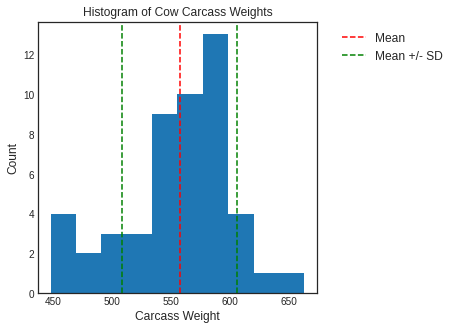

In [ ]:
fontdic = {"fontsize":12}
plt.figure(figsize = [5,5])
plt.title("Histogram of Cow Carcass Weights", fontdict=fontdic)
plt.xlabel("Carcass Weight", fontdic)
plt.ylabel("Count", fontdic)
plt.axvline(weights_data["Weight"].mean(), c = "r", linestyle = "--")
plt.axvline(weights_data["Weight"].mean() + weights_data["Weight"].std(), c = "g", linestyle = "--")
plt.axvline(weights_data["Weight"].mean() - weights_data["Weight"].std(), c = "g", linestyle = "--")
plt.hist(weights_data["Weight"])
plt.legend(["Mean", "Mean +/- SD"], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12)
plt.show()


In [ ]:
mean_weight = weights_data["Weight"].mean()
median_weight = weights_data["Weight"].median()
sd_weight = weights_data["Weight"].std()
max_weight = weights_data["Weight"].max()
min_weight = weights_data["Weight"].min()

summary_stats_weight = np.array([mean_weight, median_weight, sd_weight, max_weight, min_weight]).round(2)

In [ ]:
index = ["Mean", "Median", "SD", "Max", "Min"]

summary_stats_weight = pd.DataFrame(summary_stats_weight, index = index).transpose()

summary_stats_weight.head()

,Mean,Median,SD,Max,Min
0,557.18,573.2,48.57,663.0,447.8


In [ ]:
summary_stats_weight.to_csv("/content/drive/My Drive/Master/Thesis/summary_stats_weight.csv")

### Estimated Body Measures (All Images)

Merge the body measures to the weights

In [ ]:
## Both data frames have the image names as index -- Merge can be done simply with the pd.DataFrame.join() w/o other specs

data = weights_data.join(results_body_measures)

In [ ]:
data.head()

,ID,Weight,Age,Body_Length,Hip_Height,Hip_Width,Heart_Girth
Image,,,,,,,
591158734-6.jpg,1360,538.8,615,0.000050,0.000408,0.000363,0.000746
591158757-1.jpg,2799,589.0,535,0.000053,0.000481,0.000416,0.000861
591158798-0.jpg,4952,461.6,556,0.000056,0.000699,0.000650,0.000846
591158836-1.jpg,2795,532.0,542,0.000341,0.000762,0.001502,0.001068
591158931-9.jpg,2799,589.0,535,0.000039,0.003142,0.002856,0.000631


In [ ]:
print("The resulting data frame has {} columns and {} rows.".format(data.shape[1], data.shape[0]))

The resulting data frame has 7 columns and 50 rows.


Descriptive Analysis

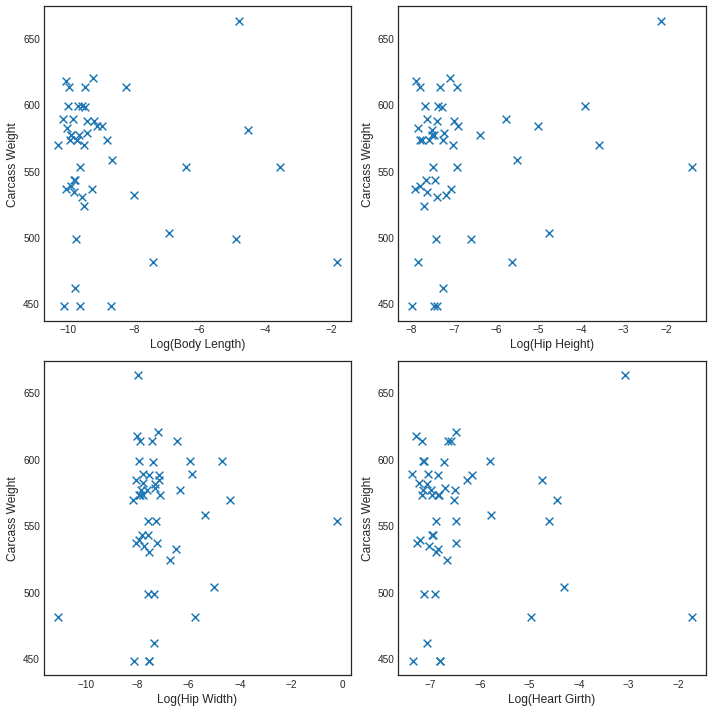

In [ ]:
plt.figure(figsize = [10,10])

for index, column in enumerate(data.columns[3:]):
  plt.subplot(2,2,index+1)
  plt.xlabel("Log(" + column.replace("_", " ") + ")", fontsize = 12)
  plt.ylabel("Carcass Weight", fontsize = 12)
  plt.scatter(x = np.log(data.loc[:,column]), y = data.loc[:,"Weight"], s = 60, marker = "x")

plt.tight_layout()
plt.show()

Standardise and split the data

In [ ]:
X = data.loc[:,data.columns[3:]]
y = data.loc[:, "Weight"]

In [ ]:
X = scale(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Use **SVR** to estimate weight

In [ ]:
svr = SVR()

svr_fit = svr.fit(X_train, y_train)

svr_predict = svr_fit.predict(X_test)

svr_predict_train = svr_fit.predict(X_train)

Use **Linear Regression** to estimate weight

In [ ]:
lm = LinearRegression()

lm_fit = lm.fit(X_train, y_train)

lm_predict = lm_fit.predict(X_test)

lm_predict_train = lm_fit.predict(X_train)

### Annotated Body Measures

In [ ]:
data_annotated = weights_data.join(results_body_measures_annotated)

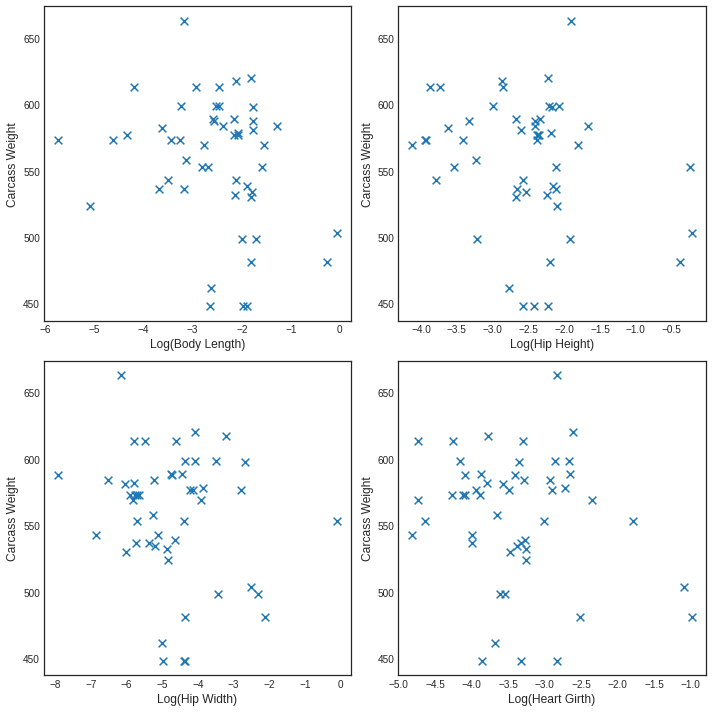

In [ ]:
plt.figure(figsize = [10,10])

for index, column in enumerate(data_annotated.columns[3:]):
  plt.subplot(2,2,index+1)
  plt.xlabel("Log(" + column.replace("_", " ") + ")", fontsize = 12)
  plt.ylabel("Carcass Weight", fontsize = 12)
  plt.scatter(x = np.log(data_annotated.loc[:,column]), y = data_annotated.loc[:,"Weight"], s = 60, marker = "x")

plt.tight_layout()
plt.show()

In [ ]:
X = data_annotated.loc[:,data_annotated.columns[3:]]
y = data_annotated.loc[:, "Weight"]

In [ ]:
X = scale(X)

In [ ]:
X_train_annotated, X_test_annotated, y_train_annotated, y_test_annotated = train_test_split(X, y, test_size = 0.2)

In [ ]:
svr_annotated = SVR()

svr_annotated_fit = svr_annotated.fit(X_train_annotated, y_train_annotated)

svr_annotated_predict = svr_annotated_fit.predict(X_test_annotated)

svr_annotated_predict_train = svr_annotated_fit.predict(X_train_annotated)

In [ ]:
lm_annotated = LinearRegression()

lm_annotated_fit = lm_annotated.fit(X_train_annotated, y_train_annotated)

lm_annotated_predict = lm_annotated_fit.predict(X_test_annotated)

lm_annotated_predict_train = lm_annotated_fit.predict(X_train_annotated)

### Estimated Body Measures (Good Images Only)

In [ ]:
## Both data frames have the image names as index -- Merge can be done simply with the pd.DataFrame.join() w/o other specs

data_good_images = weights_data.join(results_body_measures_good_images).dropna()

In [ ]:
data_good_images.head()

,ID,Weight,Age,Body_Length,Hip_Height,Hip_Width,Heart_Girth
Image,,,,,,,
591158798-0.jpg,4952,461.6,556,0.075787,0.010610,0.055035,0.000007
591159136-9.jpg,8920,447.8,567,0.081613,0.008128,0.052373,0.000005
591159161-5.jpg,8933,481.2,546,0.039977,0.026273,0.000000,0.000016
591159238-0.jpg,8933,481.2,546,0.012736,0.012736,0.000799,0.000004
591159277-4.jpg,745,581.8,537,0.000003,0.000004,0.071419,0.000000


In [ ]:
print("The resulting data frame has {} columns and {} rows.".format(data_good_images.shape[1], data_good_images.shape[0]))

The resulting data frame has 7 columns and 26 rows.


Descriptive Analysis

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


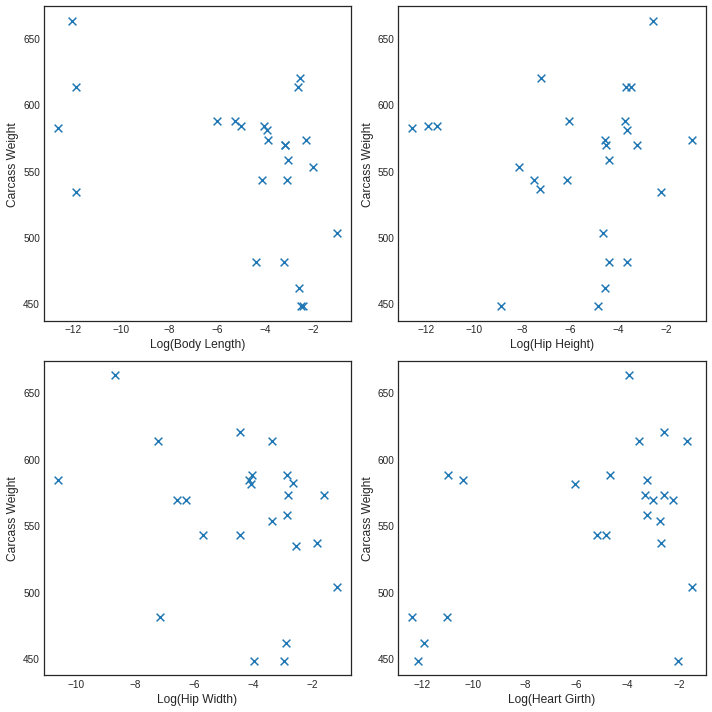

In [ ]:
plt.figure(figsize = [10,10])

for index, column in enumerate(data_good_images.columns[3:]):
  plt.subplot(2,2,index+1)
  plt.xlabel("Log(" + column.replace("_", " ") + ")", fontsize = 12)
  plt.ylabel("Carcass Weight", fontsize = 12)
  plt.scatter(x = np.log(data_good_images.loc[:,column]), y = data_good_images.loc[:,"Weight"], s = 60, marker = "x")

plt.tight_layout()
plt.show()

Standardise and split the data

In [ ]:
X = data_good_images.loc[:,data_good_images.columns[3:]]
y = data_good_images.loc[:, "Weight"]

In [ ]:
X = scale(X)

In [ ]:
X_train_good_images, X_test_good_images, y_train_good_images, y_test_good_images = train_test_split(X, y, test_size = 0.2)

Use **SVR** to estimate weight

In [ ]:
svr_good_images = SVR()

svr_fit_good_images = svr_good_images.fit(X_train_good_images, y_train_good_images)

svr_predict_good_images = svr_fit_good_images.predict(X_test_good_images)

svr_predict_train_good_images = svr_fit_good_images.predict(X_train_good_images)

Use **Linear Regression** to estimate weight

In [ ]:
lm_good_images = LinearRegression()

lm_fit_good_images = lm_good_images.fit(X_train_good_images, y_train_good_images)

lm_predict_good_images = lm_fit_good_images.predict(X_test_good_images)

lm_predict_train_good_images = lm_fit_good_images.predict(X_train_good_images)

## 3) Evaluation

### Estimated Body Measures (All Images)

SVR

In [ ]:
test_error = y_test - svr_predict
train_error = y_train - svr_predict_train

train_MAE_svr_all_images = mean_absolute_error(y_true = y_train, y_pred = svr_predict_train)
train_MAPE_svr_all_images = np.mean(np.abs(train_error)/y_train)*100
test_MAE_svr_all_images = mean_absolute_error(y_true = y_test, y_pred = svr_predict)
test_MAPE_svr_all_images = np.mean(np.abs(test_error)/y_test)*100

print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(train_MAE_svr_all_images, train_MAPE_svr_all_images))
print("---------------------------------------------------------")
print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(test_MAE_svr_all_images, test_MAPE_svr_all_images))

The test MAE is: 34.54 
The test MAPE is: 6.61%
---------------------------------------------------------
The test MAE is: 44.94 
The test MAPE is: 8.88%


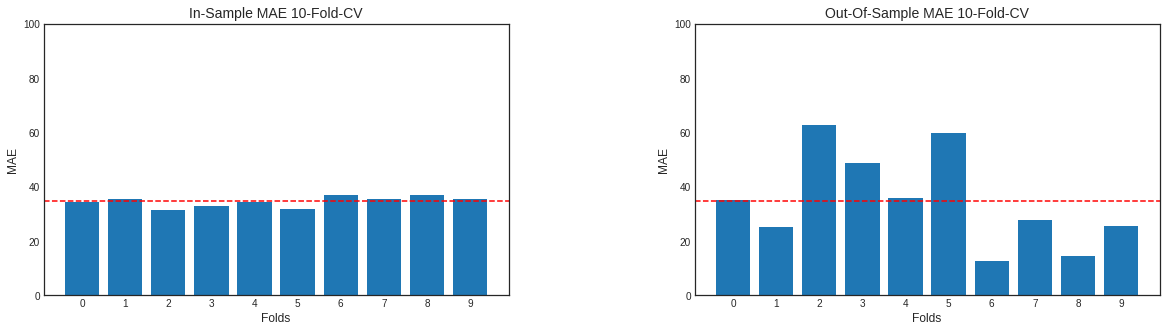

The training sample mean MAE for the 10 folds is: 34.81 
The test sample mean MAE for the 10 folds is: 34.81


In [ ]:
pipe_svr = make_pipeline(StandardScaler(), SVR())

cv = cross_validate(pipe_svr, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True, scoring = "neg_mean_absolute_error")

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("In-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,100])


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("Out-Of-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0, 100])

plt.tight_layout
plt.show()



mean_MAE_train = cv["test_score"].mean()*(-1)
mean_MAE_test = cv["test_score"].mean()*(-1)

print("The training sample mean MAE for the 10 folds is: {:.2f} \nThe test sample mean MAE for the 10 folds is: {:.2f}".format(mean_MAE_train, mean_MAE_test))

Linear Regression

In [ ]:
train_error = y_train - lm_predict_train
train_MAE_lm_all_images = mean_absolute_error(y_true = y_train, y_pred = lm_predict_train)
train_MAPE_lm_all_images = np.mean(np.abs(train_error)/y_train)*100

test_error = y_test - lm_predict
test_MAE_lm_all_images = mean_absolute_error(y_true = y_test, y_pred = lm_predict)
test_MAPE_lm_all_images = np.mean(np.abs(test_error)/y_test)*100

print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(train_MAE_lm_all_images, train_MAPE_lm_all_images))
print("---------------------------------------------------------")
print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(test_MAE_lm_all_images, test_MAPE_lm_all_images))

The test MAE is: 32.15 
The test MAPE is: 6.03%
---------------------------------------------------------
The test MAE is: 87.27 
The test MAPE is: 16.31%


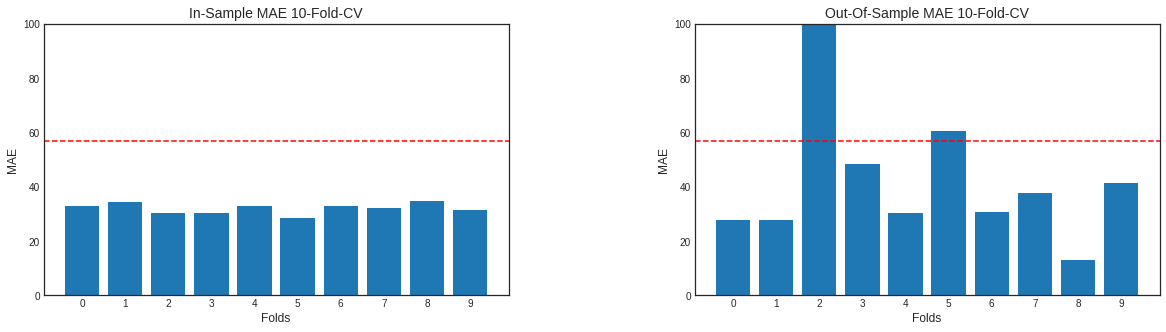

The training sample mean MAE for the 10 folds is: 56.93 
The test sample mean MAE for the 10 folds is: 56.93


In [ ]:
pipe_lm = make_pipeline(StandardScaler(), lm)

cv_lm = cross_validate(pipe_lm, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True, scoring = "neg_mean_absolute_error")

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv_lm["train_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("In-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_lm["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,100])


fig.add_subplot(1, 2, 2)
plt.bar(height = cv_lm["test_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("Out-Of-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_lm["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0, 100])

plt.tight_layout
plt.show()


mean_MAE_train = cv_lm["test_score"].mean()*(-1)
mean_MAE_test = cv_lm["test_score"].mean()*(-1)

print("The training sample mean MAE for the 10 folds is: {:.2f} \nThe test sample mean MAE for the 10 folds is: {:.2f}".format(mean_MAE_train, mean_MAE_test))

### Annotated Body Measures


SVR

In [ ]:
train_error = y_train_annotated - svr_annotated_predict_train
train_MAE_svr_annotated = mean_absolute_error(y_true = y_train_annotated, y_pred = svr_annotated_predict_train)
train_MAPE_svr_annotated = np.mean(np.abs(train_error)/y_train_annotated)*100

test_error = y_test_annotated - svr_annotated_predict
test_MAE_svr_annotated = mean_absolute_error(y_true = y_test_annotated, y_pred = svr_annotated_predict)
test_MAPE_svr_annotated = np.mean(np.abs(test_error)/y_test_annotated)*100

print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(train_MAE_svr_annotated, train_MAPE_svr_annotated))
print("---------------------------------------------------------")
print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(test_MAE_svr_annotated, test_MAPE_svr_annotated))

The test MAE is: 35.66 
The test MAPE is: 6.81%
---------------------------------------------------------
The test MAE is: 39.88 
The test MAPE is: 7.85%


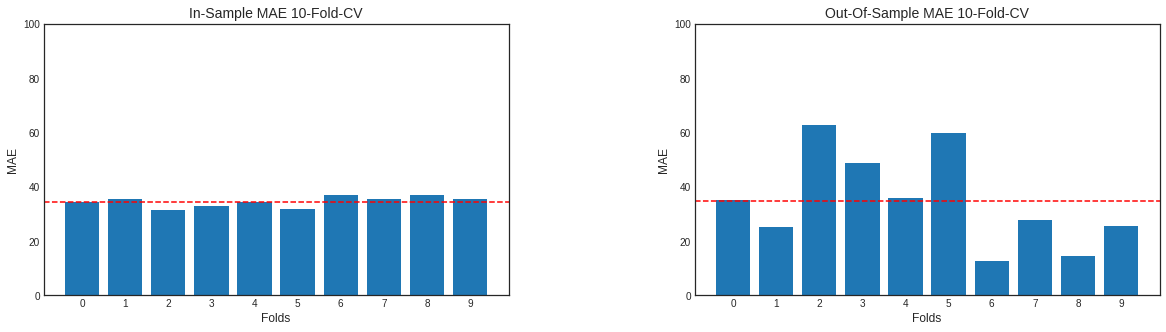

The training sample mean MAE for the 10 folds is: 34.48 
The test sample mean MAE for the 10 folds is: 34.81


In [ ]:
pipe_svr_annotated = make_pipeline(StandardScaler(), svr_annotated)

cv_svr_annotated = cross_validate(pipe_svr_annotated, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True, scoring = "neg_mean_absolute_error")

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv_svr_annotated["train_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("In-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_svr_annotated["train_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,100])


fig.add_subplot(1, 2, 2)
plt.bar(height = cv_svr_annotated["test_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("Out-Of-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_svr_annotated["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0, 100])

plt.tight_layout
plt.show()


mean_MAE_train = cv_svr_annotated["train_score"].mean()*(-1)
mean_MAE_test = cv_svr_annotated["test_score"].mean()*(-1)

print("The training sample mean MAE for the 10 folds is: {:.2f} \nThe test sample mean MAE for the 10 folds is: {:.2f}".format(mean_MAE_train, mean_MAE_test))

Linear Regression

In [ ]:
train_error = y_train_annotated - lm_annotated_predict_train
train_MAE_lm_annotated = mean_absolute_error(y_true = y_train_annotated, y_pred = lm_annotated_predict_train)
train_MAPE_lm_annotated = np.mean(np.abs(train_error)/lm_annotated_predict_train)*100

test_error = y_test_annotated - lm_annotated_predict
test_MAE_lm_annotated = mean_absolute_error(y_true = y_test_annotated, y_pred = lm_annotated_predict)
test_MAPE_lm_annotated = np.mean(np.abs(test_error)/y_test_annotated)*100

print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(train_MAE_lm_annotated, train_MAPE_lm_annotated))
print("---------------------------------------------------------")
print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(test_MAE_lm_annotated, test_MAPE_lm_annotated))

The test MAE is: 32.22 
The test MAPE is: 5.81%
---------------------------------------------------------
The test MAE is: 52.80 
The test MAPE is: 9.99%


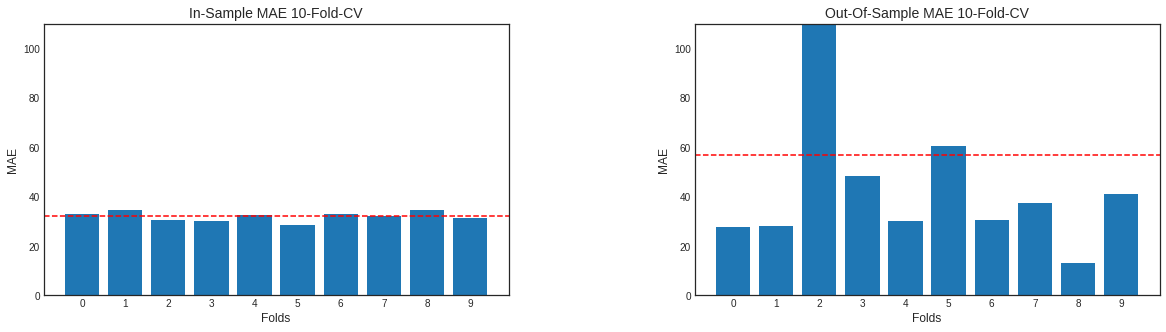

The training sample mean MAE for the 10 folds is: 31.96 
The test sample mean MAE for the 10 folds is: 56.93


In [ ]:
pipe_lm_annotated = make_pipeline(StandardScaler(), lm_annotated)

cv_lm_annotated = cross_validate(pipe_lm_annotated, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True, scoring = "neg_mean_absolute_error")

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv_lm_annotated["train_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("In-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_lm_annotated["train_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,110])


fig.add_subplot(1, 2, 2)
plt.bar(height = cv_lm_annotated["test_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("Out-Of-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_lm_annotated["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,110])
plt.tight_layout
plt.show()


mean_MAE_train = cv_lm_annotated["train_score"].mean()*(-1)
mean_MAE_test = cv_lm_annotated["test_score"].mean()*(-1)

print("The training sample mean MAE for the 10 folds is: {:.2f} \nThe test sample mean MAE for the 10 folds is: {:.2f}".format(mean_MAE_train, mean_MAE_test))

### Estimated Body Measures (Good Images Only)

SVR

In [ ]:
train_error = y_train_good_images - svr_predict_train_good_images
train_MAE_svr_good_images =  mean_absolute_error(y_true = y_train_good_images, y_pred = svr_predict_train_good_images)
train_MAPE_svr_good_images = np.mean(np.abs(train_error)/y_train_good_images)*100

test_error = y_test_good_images - svr_predict_good_images
test_MAE_svr_good_images = mean_absolute_error(y_true = y_test_good_images, y_pred = svr_predict_good_images)
test_MAPE_svr_good_images = np.mean(np.abs(test_error)/y_test_good_images)*100

print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(train_MAE_svr_good_images, train_MAPE_svr_good_images))
print("---------------------------------------------------------")
print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(test_MAE_svr_good_images, test_MAPE_svr_good_images))

The test MAE is: 31.45 
The test MAPE is: 6.15%
---------------------------------------------------------
The test MAE is: 71.87 
The test MAPE is: 13.80%


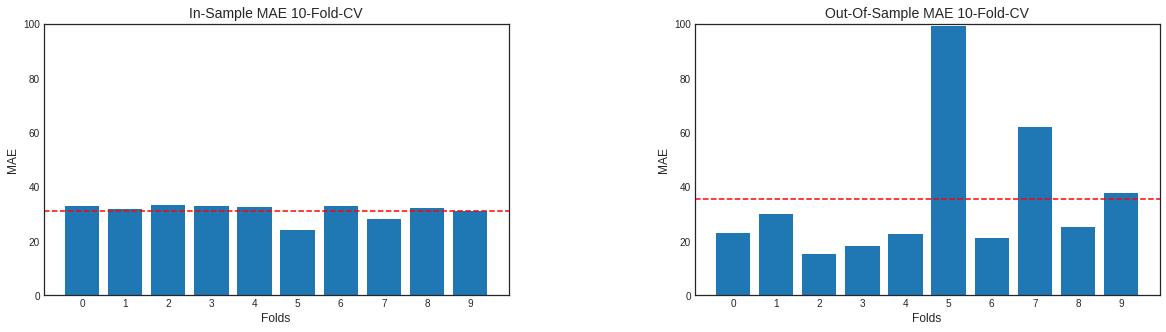

The training sample mean MAE for the 10 folds is: 31.16 
The test sample mean MAE for the 10 folds is: 35.37


In [ ]:
pipe_svr_good_images = make_pipeline(StandardScaler(), svr_good_images)

cv_svr_good_images = cross_validate(pipe_svr_good_images, X_train_good_images, y_train_good_images, cv = 10, return_train_score= True, return_estimator= True, scoring = "neg_mean_absolute_error")

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv_svr_good_images["train_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("In-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_svr_good_images["train_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,100])


fig.add_subplot(1, 2, 2)
plt.bar(height = cv_svr_good_images["test_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("Out-Of-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_svr_good_images["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0, 100])

plt.tight_layout
plt.show()


mean_MAE_train = cv_svr_good_images["train_score"].mean()*(-1)
mean_MAE_test = cv_svr_good_images["test_score"].mean()*(-1)

print("The training sample mean MAE for the 10 folds is: {:.2f} \nThe test sample mean MAE for the 10 folds is: {:.2f}".format(mean_MAE_train, mean_MAE_test))

Linear Regression

In [ ]:
test_error = y_test_good_images - lm_predict_good_images
train_MAE_lm_good_images =  mean_absolute_error(y_true = y_train_good_images, y_pred = lm_predict_train_good_images)
train_MAPE_lm_good_images = np.mean(np.abs(train_error)/lm_predict_train_good_images)*100

train_error = y_train_good_images - lm_predict_train_good_images
test_MAE_lm_good_images = mean_absolute_error(y_true = y_test_good_images, y_pred = lm_predict_good_images)
test_MAPE_lm_good_images = np.mean(np.abs(test_error)/y_test_good_images)*100

print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(train_MAE_lm_good_images, train_MAPE_lm_good_images))
print("---------------------------------------------------------")
print("The test MAE is: {:.2f} \nThe test MAPE is: {:.2f}%".format(test_MAE_lm_good_images, test_MAPE_lm_good_images))

The test MAE is: 28.92 
The test MAPE is: 5.88%
---------------------------------------------------------
The test MAE is: 76.35 
The test MAPE is: 15.00%


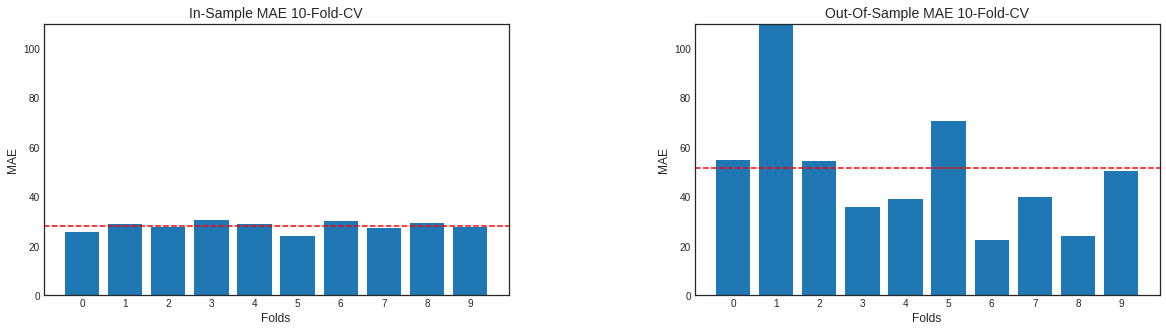

The training sample mean MAE for the 10 folds is: 27.99 
The test sample mean MAE for the 10 folds is: 51.53


In [ ]:
pipe_lm_good_images = make_pipeline(StandardScaler(), lm_good_images)

cv_lm_good_images = cross_validate(pipe_lm_good_images, X_train_good_images, y_train_good_images, cv = 10, return_train_score= True, return_estimator= True, scoring = "neg_mean_absolute_error")

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv_lm_good_images["train_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("In-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_lm_good_images["train_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,110])


fig.add_subplot(1, 2, 2)
plt.bar(height = cv_lm_good_images["test_score"]*(-1), x = np.arange(10))
plt.xticks(np.arange(10))
plt.xlabel("Folds", fontdict={"fontsize":12})
plt.ylabel("MAE", fontdict={"fontsize":12})
plt.title("Out-Of-Sample MAE 10-Fold-CV", fontdict={"fontsize":14})
plt.axhline(cv_lm_good_images["test_score"].mean()*(-1), c = "red", ls = "--")
plt.ylim([0,110])
plt.tight_layout
plt.show()


mean_MAE_train = cv_lm_good_images["train_score"].mean()*(-1)
mean_MAE_test = cv_lm_good_images["test_score"].mean()*(-1)

print("The training sample mean MAE for the 10 folds is: {:.2f} \nThe test sample mean MAE for the 10 folds is: {:.2f}".format(mean_MAE_train, mean_MAE_test))

### Save Results

In [ ]:
path = "/content/drive/My Drive/Master/Thesis/Carcass Weight Results"

In [ ]:
def results_to_dataframe(data):

  result = pd.DataFrame(data,
                        columns = ["MAE", "MAPE"],
                        index = index)
    
  return result

In [ ]:
all_images_results = np.array([train_MAE_svr_all_images, train_MAPE_svr_all_images, test_MAE_svr_all_images, test_MAPE_svr_all_images,
                               train_MAE_lm_all_images, train_MAPE_lm_all_images, test_MAE_lm_all_images, test_MAPE_lm_all_images]).reshape((4,2)).round(4)

annotation_results = np.array([train_MAE_svr_annotated, train_MAPE_svr_annotated, test_MAE_svr_annotated, test_MAPE_svr_annotated,
                               train_MAE_lm_annotated, train_MAPE_lm_annotated, test_MAE_lm_annotated, test_MAPE_lm_annotated]).reshape(4,2).round(4)

In [ ]:
good_images_results = np.array([train_MAE_svr_good_images, train_MAPE_svr_good_images, test_MAE_svr_good_images, test_MAPE_svr_good_images,
                               train_MAE_lm_good_images, train_MAPE_lm_good_images, test_MAE_lm_good_images, test_MAPE_lm_good_images]).reshape((4,2))

In [ ]:
index = ["Train - SVR", "Test - SVR", "Train - LM", "Test - LM"]

In [ ]:
results = []

results.append(results_to_dataframe(all_images_results))
results.append(results_to_dataframe(annotation_results))

all_images_results = results_to_dataframe(all_images_results)
annotation_results = results_to_dataframe(annotation_results)

all_images_results.to_csv(os.path.join(path, "All_Images.csv"))
annotation_results.to_csv(os.path.join(path, "Annotation.csv"))

print("These are the results for all images: \n{}".format(results[0]))
print("\nThese are the results for the annotated keypoints: \n{}".format(results[1]))

These are the results for all images: 
                 MAE     MAPE
Train - SVR  34.5377   6.6100
Test - SVR   44.9445   8.8842
Train - LM   32.1514   6.0265
Test - LM    87.2744  16.3136

These are the results for the annotated keypoints: 
                 MAE    MAPE
Train - SVR  35.6584  6.8094
Test - SVR   39.8844  7.8506
Train - LM   32.2211  5.8103
Test - LM    52.8021  9.9915


In [ ]:
good_images_results = results_to_dataframe(good_images_results)
good_images_results.to_csv(os.path.join(path, "Good_Images.csv"))

Plot The Results

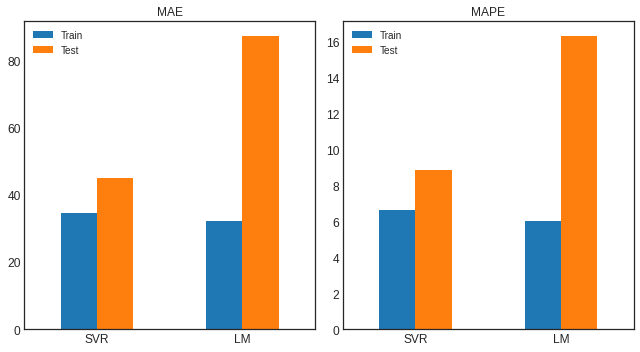

In [ ]:
MAE_all_images = pd.DataFrame(results_to_dataframe(all_images_results).values[:,0].reshape((2,2)), index = ["SVR", "LM"], columns = ["Train", "Test"])
MAPE_all_images = pd.DataFrame(results_to_dataframe(all_images_results).values[:,1].reshape((2,2)), index = ["SVR", "LM"], columns = ["Train", "Test"])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [9,5])
MAE_all_images.plot(ax=axes[0], kind = "bar", title = "MAE", rot = 0, fontsize = 12)

MAPE_all_images.plot(ax=axes[1], kind = "bar", title = "MAPE", rot = 0, fontsize = 12)


plt.tight_layout()
plt.show()


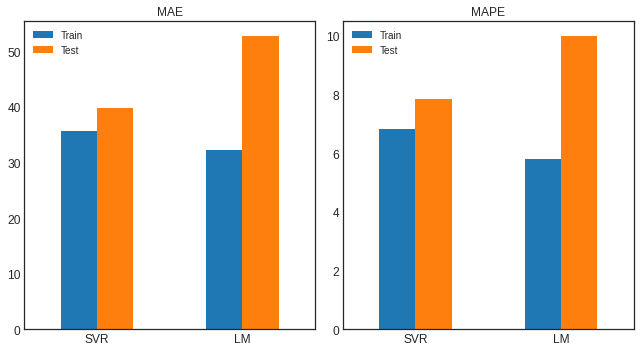

In [ ]:
MAE_all_images = pd.DataFrame(results_to_dataframe(annotation_results).values[:,0].reshape((2,2)), index = ["SVR", "LM"], columns = ["Train", "Test"])
MAPE_all_images = pd.DataFrame(results_to_dataframe(annotation_results).values[:,1].reshape((2,2)), index = ["SVR", "LM"], columns = ["Train", "Test"])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [9,5])
MAE_all_images.plot(ax=axes[0], kind = "bar", title = "MAE", rot = 0, fontsize = 12)

MAPE_all_images.plot(ax=axes[1], kind = "bar", title = "MAPE", rot = 0, fontsize = 12)


plt.tight_layout()
plt.show()

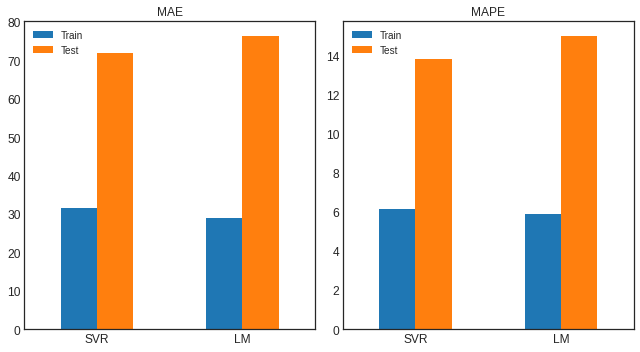

In [ ]:
MAE_all_images = pd.DataFrame(results_to_dataframe(good_images_results).values[:,0].reshape((2,2)), index = ["SVR", "LM"], columns = ["Train", "Test"])
MAPE_all_images = pd.DataFrame(results_to_dataframe(good_images_results).values[:,1].reshape((2,2)), index = ["SVR", "LM"], columns = ["Train", "Test"])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [9,5])
MAE_all_images.plot(ax=axes[0], kind = "bar", title = "MAE", rot = 0, fontsize = 12)

MAPE_all_images.plot(ax=axes[1], kind = "bar", title = "MAPE", rot = 0, fontsize = 12)


plt.tight_layout()
plt.show()

Body Measures from Estimated Keypoints vs. from Annotated Keypoints

In [ ]:
error = np.abs(results_body_measures - results_body_measures_annotated)/results_body_measures_annotated

error = error.mean(axis = 0).round(4)

error.to_csv("/content/drive/My Drive/Master/Thesis/annotated_vs_estimated.csv")


In [ ]:
error2 = np.abs(results_body_measures* - results_body_measures_annotated)/results_body_measures_annotated

error2.mean(axis = 0).round(4)

Body_Length    0.9977
Hip_Height     0.9134
Hip_Width      0.9280
Heart_Girth    0.9142
dtype: float64

In [ ]:
results_body_measures.head()


,Body_Length,Hip_Height,Hip_Width,Heart_Girth
585216074-0.jpg,0.000056,0.000291,0.000405,0.000862
586290717-8.jpg,0.000046,0.000260,0.000362,0.000752
586290925-7.jpg,0.000112,0.000340,0.000508,0.002040
589454323-0.jpg,0.000082,0.001139,0.000967,0.001749
589454978-8.jpg,0.000048,0.000569,0.000505,0.000785


In [ ]:
results_body_measures_annotated.head()

,Body_Length,Hip_Height,Hip_Width,Heart_Girth
585216074-0.jpg,0.058128,0.050881,0.083698,0.015838
586290717-8.jpg,0.042164,0.084113,0.073106,0.009901
586290925-7.jpg,0.067637,0.055564,0.005718,0.027797
589454323-0.jpg,0.012839,0.143285,0.017087,0.022151
589454978-8.jpg,0.022090,0.057575,0.000508,0.018019
